<a href="https://colab.research.google.com/github/max-aifer/quantum-sync/blob/master/sync_fig1_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import scipy.stats as stats
import scipy.optimize as optimize
import numpy as np
from scipy.linalg import logm, expm
import matplotlib.pyplot as plt

from numpy import log
from numpy import trace
from numpy.linalg import det, inv


In [2]:
"""Math helper functions"""
def ct(x):
  """Conjugate transpose"""
  return np.conj(np.transpose(x))

def coth(x):
  return np.cosh(x)/np.sinh(x)

def arccoth(x):
  """Inverse hyperbolic cotangent"""
  return np.arctanh(1.0/x)

def cothm(A):
  """Matrix hyperbolic cotangent"""
  # get eigenvalues and eigenvectors
  w, v = np.linalg.eig(A)
  # take coth of eigenvalues
  w = coth(w)
  # return matrix
  return v @ np.diag(w) @ np.linalg.inv(v)

def arccothm(A):
  """Matrix hyperbolic cotangent"""
  # get eigenvalues and eigenvectors
  w, v = np.linalg.eig(A)
  # take coth of eigenvalues
  w = arccoth(w)
  # return matrix
  return v @ np.diag(w) @ np.linalg.inv(v)

"""Symplectic form"""
Omega1 = np.array([[0, 1],
                  [-1, 0]])
Omega = np.block([[Omega1, np.zeros((2,2))],
                 [np.zeros((2,2)),Omega1]])

"""Params"""
om1 = 1.
om2 = 1.

In [8]:
"""Classical"""
def get_E(sigma, mu=np.zeros(4)):
  r_sq = np.diag(sigma) + mu**2
  E = om1 * (r_sq[0] + r_sq[1])/2 + om2 * (r_sq[2] + r_sq[3])/2
  return E

def get_sigma_eq(E):
  return np.diag([E / (2 * om1), E / (2 * om1), E / (2 * om2), E / (2 * om2)])

def get_D(sigma, mu=np.zeros(4)):
    r2 = np.diag(sigma) + mu**2
    Cx = sigma[0,2] + mu[0] * mu[2]
    Cp = sigma[1,3] + mu[1] * mu[3]
    dx2 = r2[0] + r2[2] - 2*Cx
    dp2 = r2[1] + r2[3] - 2*Cp
    d2 = dx2 + dp2
    D = np.sqrt(d2/np.sum(r2))
    return D

def sigma_from_H_cl(H, beta=1.0):
  sigma = inv(H)/(2 * beta)
  return sigma

def H_from_sigma_cl(sigma, beta=1.0):
   H = inv(sigma) / (2*beta)
   return H

def S_cl(sigma):
  return 0.5 * log(det(2 * np.pi * np.e * sigma))

def get_GKL_cl(s1, s2, mu1, mu2):
  """Gaussian classical relative entropy"""
  k = np.shape(s1)[0]
  KL = 0.5 * (trace(inv(s2) @ s1) \
      + (mu2 - mu1).T @ inv(s2) @ (mu2 - mu1) \
          - k + np.log(det(s2)/det(s1)))
  return KL

def get_chi_cl(sigma, mu=np.zeros(4)):
  E = get_E(sigma,mu=mu)
  s0 = get_sigma_eq(E)
  chi = get_GKL_cl(sigma, s0, mu, np.zeros(4))
  return chi


In [9]:
"""Quantum"""
""" See https://markwilde.com/teaching/2019-spring-gqi/scribe-notes/lecture-09-scribed.pdf
Note that our H is Wilde's H/2 and our sigma is Wilde's sigma/2."""

def sigma_from_H_q(H, beta=1.0):
  sigma = np.real(0.5j * cothm(1j * Omega @ (beta* H)) @ Omega)
  return sigma

def H_from_sigma_q(sigma, beta=1.0):
  H = np.real(1j * arccothm(2j * Omega @ sigma) @ Omega)
  return H

def S_q(sigma):
  S_q = 0.5 * log(det(sigma + 0.5j*Omega)) +\
    0.5*trace( arccothm(2j*Omega@sigma)@(2j*Omega@sigma) )
  return np.real(S_q)

def get_chi_q(sigma, mu = np.zeros(4)):
  E = get_E(sigma, mu)
  sigma_eq = get_sigma_eq(E)
  S = S_q(sigma)
  S_eq = S_q(sigma_eq)
  return S_eq - S


In [10]:
NS = 20000
D_q = np.zeros(NS)
D_cl = np.zeros(NS)
CHI_q = np.zeros(NS)
CHI_cl = np.zeros(NS)

for i in range(NS):
  x = np.random.randn(4,4)
  H = x.T @ x * 10
  mu = np.random.randn(4)*0

  sq = sigma_from_H_q(H)
  sc = sigma_from_H_cl(H) 

  D_q[i] = get_D(sq,mu)
  D_cl[i] = get_D(sc,mu)

  CHI_q[i] = get_chi_q(sq,mu)
  CHI_cl[i] = get_chi_cl(sc,mu)




<ipython-input-2-ca2558125db1>:11: RuntimeWarning: divide by zero encountered in arctanh
  return np.arctanh(1.0/x)
<ipython-input-2-ca2558125db1>:29: RuntimeWarning: invalid value encountered in matmul
  return v @ np.diag(w) @ np.linalg.inv(v)
<ipython-input-9-f786b2aeccc2>:14: RuntimeWarning: divide by zero encountered in log
  S_q = 0.5 * log(det(sigma + 0.5j*Omega)) +\
<ipython-input-9-f786b2aeccc2>:14: RuntimeWarning: invalid value encountered in cdouble_scalars
  S_q = 0.5 * log(det(sigma + 0.5j*Omega)) +\


In [11]:
from scipy.spatial import ConvexHull

# filter data points
mask = (0<CHI_q) * (CHI_q < 100)
D_q = D_q[mask]
CHI_q = CHI_q[mask]



points_q = np.stack((D_q, CHI_q)).T
points_q[np.isnan(points_q)] = -1
hull_q = ConvexHull(points_q)

points_cl = np.stack((D_cl, CHI_cl)).T
hull_cl = ConvexHull(points_cl)

<ipython-input-17-6b7722d806a1>:13: RuntimeWarning: divide by zero encountered in log
  Chi_p = -2 * np.log(np.e* D_p/ np.sqrt(2))
<ipython-input-17-6b7722d806a1>:14: RuntimeWarning: divide by zero encountered in log
  Chi_p_cl = -2 * np.log(np.sqrt(2) * D_p)
<ipython-input-17-6b7722d806a1>:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(points_q[simplex, 0], points_q[simplex, 1], 'k-',color='red')
<ipython-input-17-6b7722d806a1>:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(points_cl[simplex, 0], points_cl[simplex, 1], 'k-',color='blue')


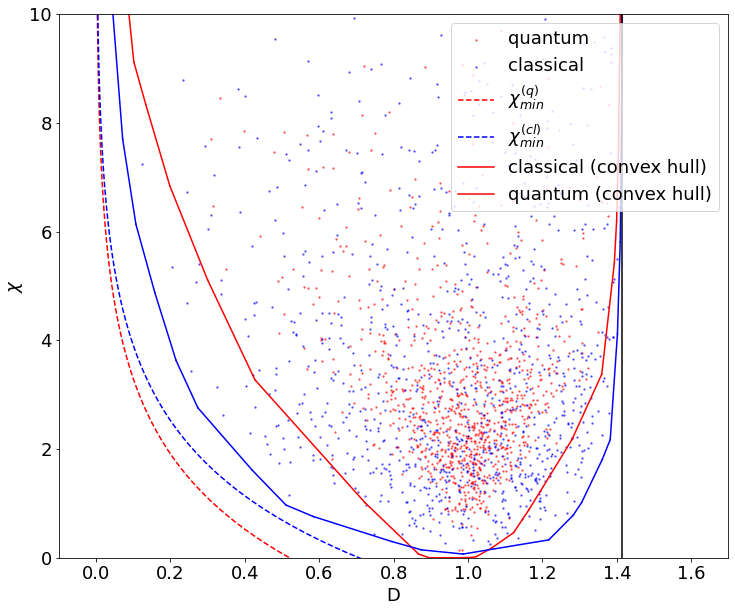

In [17]:
plt.figure(figsize=(12,10))
import matplotlib
font = {'size'   : 18}

matplotlib.rc('font', **font)

plt.scatter(D_q[:1000],CHI_q[:1000], s=2,alpha=0.5,color='red')
plt.scatter(D_cl[:1000],CHI_cl[:1000], s=2,alpha=0.5,color='blue')
plt.ylim(0,10)
plt.xlim(-.1,1.7)

D_p = np.linspace(0,2,1000)
Chi_p = -2 * np.log(np.e* D_p/ np.sqrt(2))
Chi_p_cl = -2 * np.log(np.sqrt(2) * D_p)
plt.plot(D_p, Chi_p,linestyle='--',color='red')
plt.plot(D_p, Chi_p_cl,linestyle='--',color='blue')

for simplex in hull_q.simplices:
    plt.plot(points_q[simplex, 0], points_q[simplex, 1], 'k-',color='red')

for simplex in hull_cl.simplices:
   plt.plot(points_cl[simplex, 0], points_cl[simplex, 1], 'k-',color='blue')
plt.axvline(np.sqrt(2),color='black')

plt.xlabel('D')
plt.ylabel(r'$\chi$')

plt.legend(["quantum","classical",r"$\chi_{min}^{(q)}$",r"$\chi_{min}^{(cl)}$",
            "classical (convex hull)", "quantum (convex hull)"],loc=1)